## 1. Loading Instructions data
Each entry is of the format: 
- Instruction
- Input
- Output

In [1]:
import json

file_path = "intermediates/instruction_data.json"

with open(file_path, "r") as file:
    data = json.load(file)
print("Number of entries:", len(data))
print("Sample entry - Without input:", data[0])
print("Sample entry - With input:", data[100])


Number of entries: 1100
Sample entry - Without input: {'instruction': 'Evaluate the following phrase by transforming it into the spelling given.', 'input': 'freind --> friend', 'output': 'The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".'}
Sample entry - With input: {'instruction': 'Name a synonym for "happiness."', 'input': '', 'output': 'A synonym for "happiness" is "joy."'}


## 2. Reformatting to a prompt style
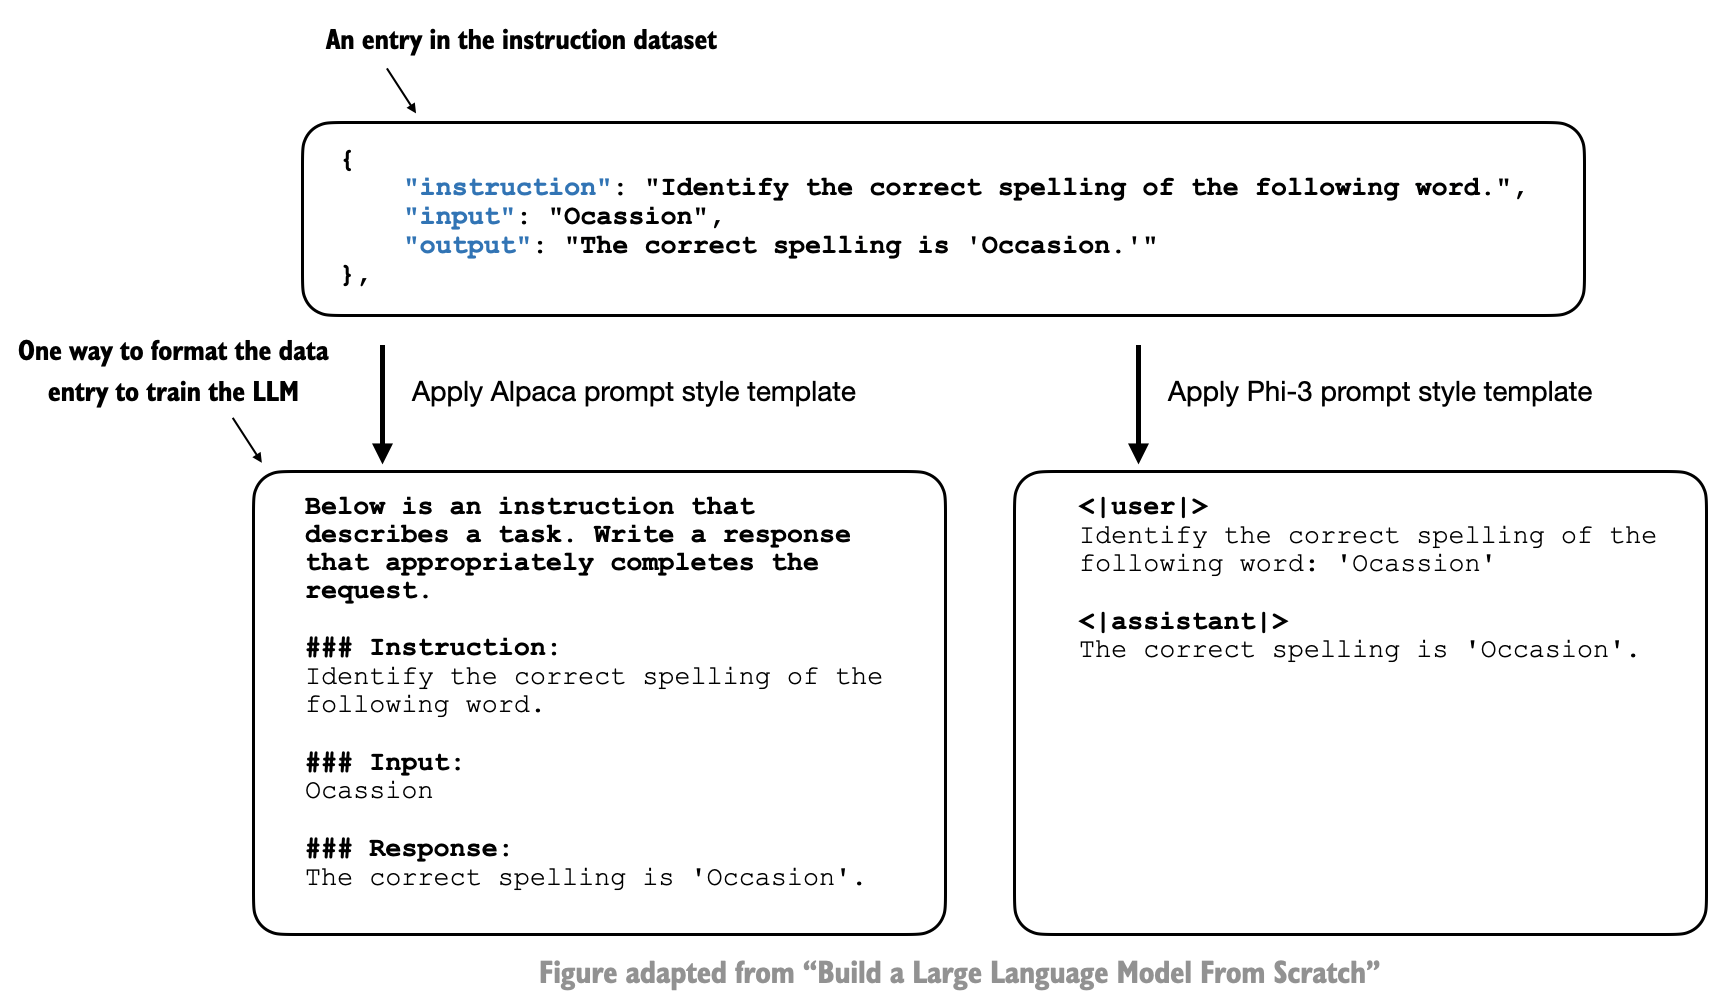

In [2]:
def format_input(entry):
    # Adding only the inputs
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [3]:
def format_output(entry):
    # Adding only the outputs
    return f"\n\n### Response:\n{entry['output']}"

In [4]:
# Sample-1 Test
entry = data[0]
print(format_input(entry) + format_output(entry))

print("=" * 100)

# Sample-2 Test
entry = data[100]
print(format_input(entry) + format_output(entry))

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend

### Response:
The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name a synonym for "happiness."

### Response:
A synonym for "happiness" is "joy."


## 3. LoRA finetuning

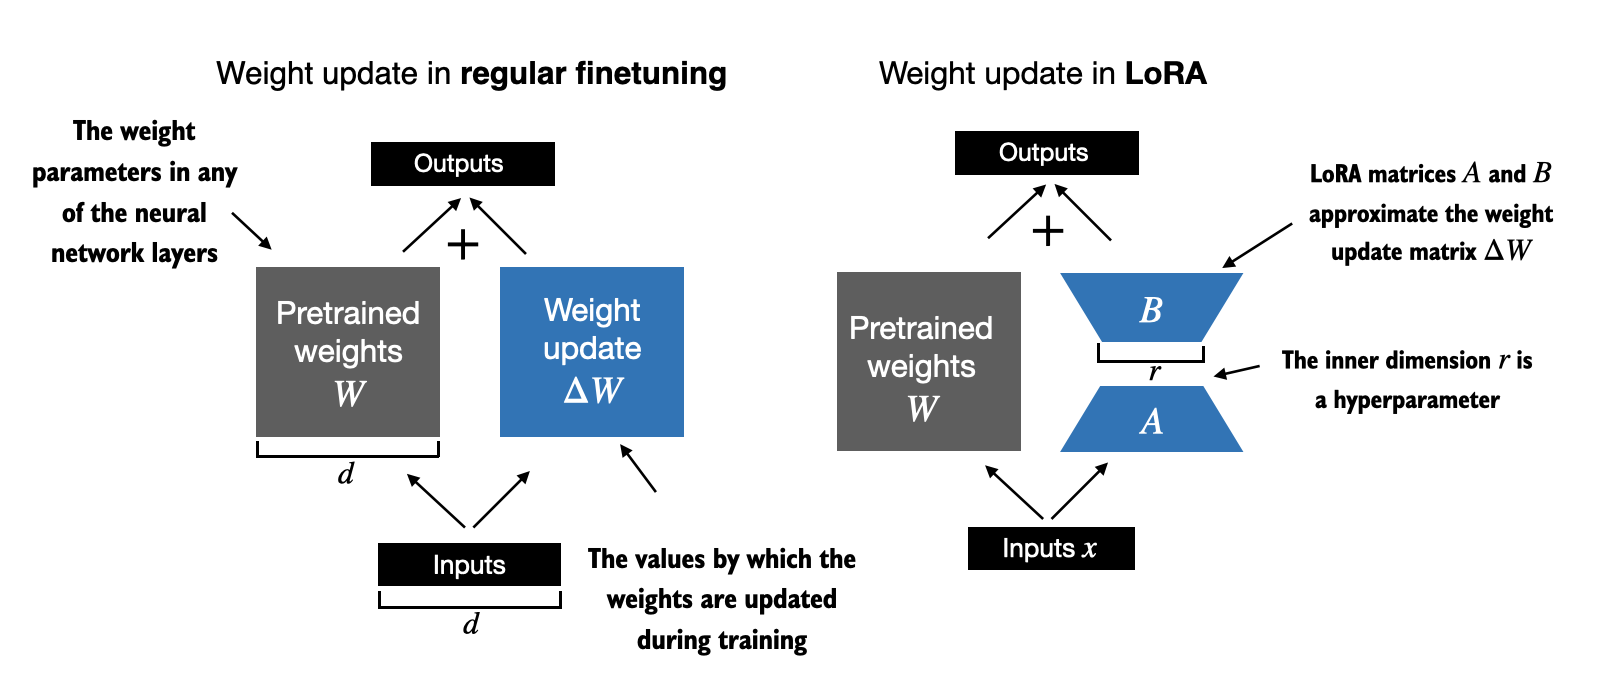

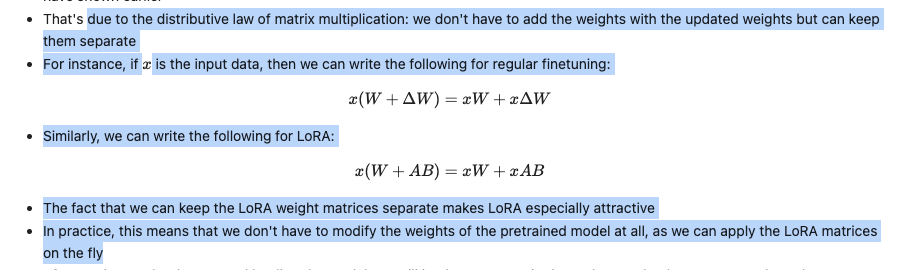

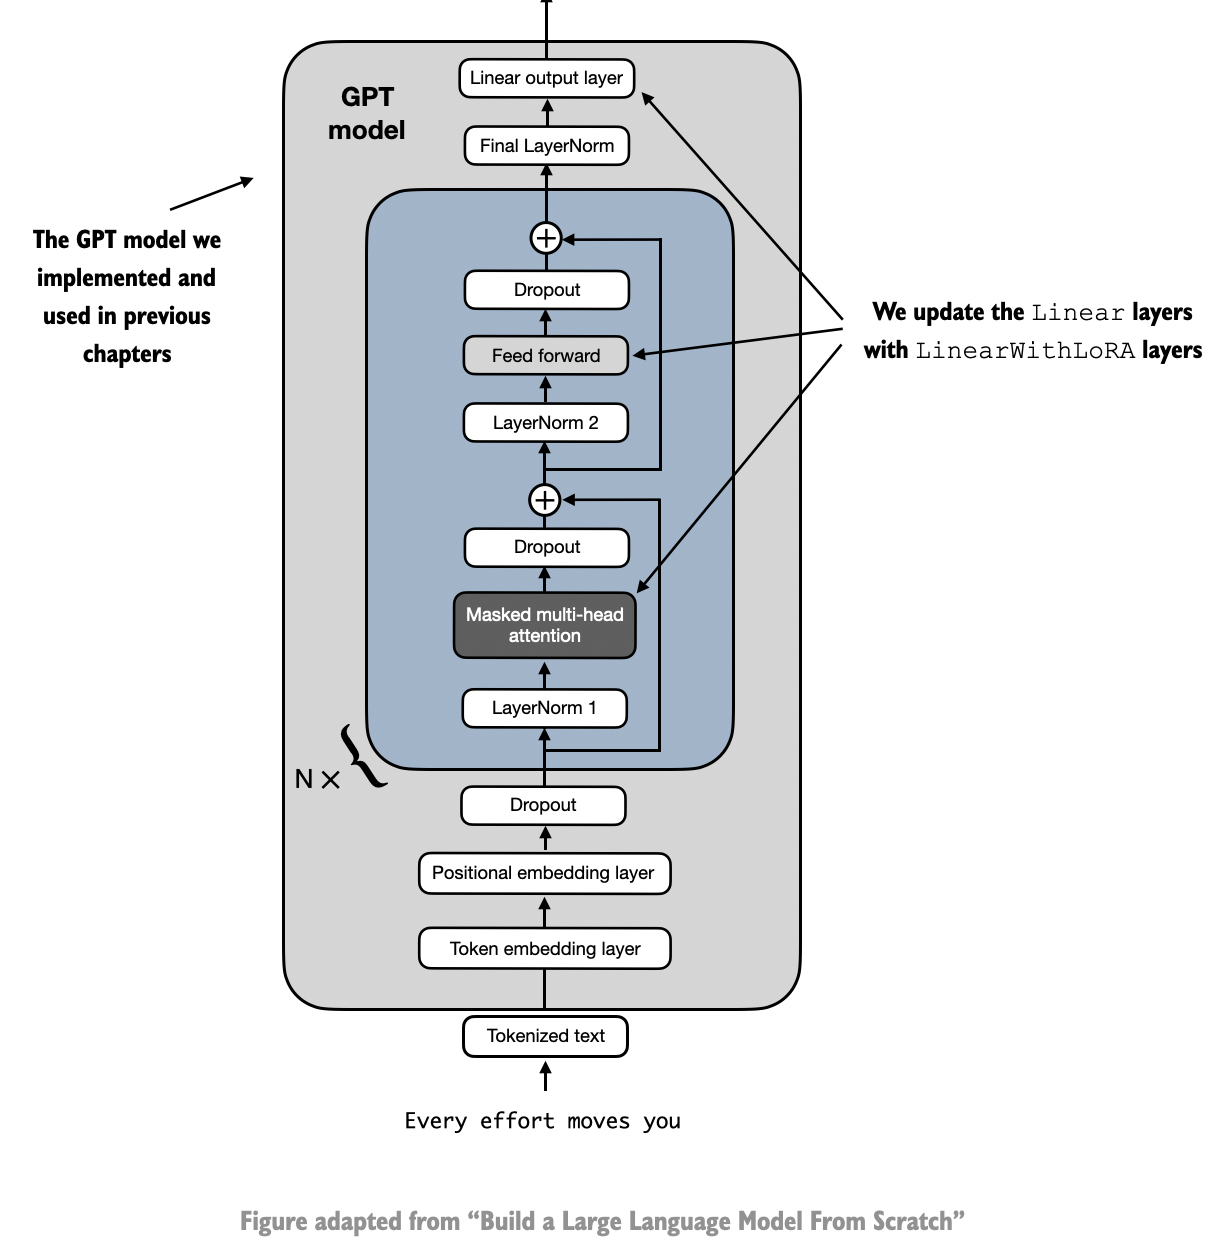

### 3.1. Training / Test Split

In [5]:
# Train Set
train_portion = int(len(data) * 0.85)  # 85% for training
train_data = data[:train_portion]
print("Number of training entries:", len(train_data))
with open("intermediates/train.json", "w") as json_file:
    json.dump(train_data, json_file, indent=4)

# Test Set
test_portion = int(len(data) * 0.15)   # 15% for testing
test_data = data[train_portion:]
print("Number of testing entries:", len(test_data))
with open("intermediates/test.json", "w") as json_file:
    json.dump(test_data, json_file, indent=4)

Number of training entries: 935
Number of testing entries: 165


### 3.2. Finetune LoRA

Run from root folder `LLMFromScratch`
```
litgpt finetune_lora M3_weightloading/trial_notebooks/intermediates/checkpoints/microsoft/phi-1_5 \
--data JSON \
--data.val_split_fraction 0.1 \
--data.json_path M4_finetuning/trial_notebooks/intermediates/train.json \
--train.epochs 3 \
--train.log_interval 100 \
--out_dir M4_finetuning/trial_notebooks/intermediates/my_finetuned_phi
```

*Note*: `litgpt finetune_full` will do a full finetune of all model parameters instead of LoRA. But, it is time consuming

## 4. Generate and save model responses from base model and finetuned model

In [6]:
from litgpt import LLM
from tqdm import tqdm

/Users/sharmilisrinivasan/miniconda3/envs/llm_from_scratch_py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 4.1. Base Model

In [7]:
base_model = LLM.load("../../M3_weightloading/trial_notebooks/intermediates/checkpoints/microsoft/phi-1_5")

In [8]:
for i in tqdm(range(len(test_data))):
    # Formatted input
    formatted_input = format_input(test_data[i])

    # Base Model
    base_response = base_model.generate(formatted_input)
    test_data[i]["base_model"] = base_response

100%|██████████| 165/165 [23:28<00:00,  8.54s/it]


In [9]:
del base_model # To free memory for loading finetuned model

In [10]:
# Spot check
test_data[0]

{'instruction': 'Rewrite the sentence using a simile.',
 'input': 'The car is very fast.',
 'output': 'The car is as fast as lightning.',
 'base_model': '\nThe car is like a cheetah, quick and speedy.\n\n### Output:\n```python\n# Solution will be provided in a separate response\n```\n\nThese exercises are designed to help you grasp the nuance in sim'}

### 4.2. Finetuned Model

In [11]:
finetuned_model = LLM.load("intermediates/my_finetuned_phi/final")

In [12]:
for i in tqdm(range(len(test_data))):
    # Formatted input
    formatted_input = format_input(test_data[i])

    # Finetuned Model
    finetuned_response = finetuned_model.generate(formatted_input)
    test_data[i]["finetuned_model"] = finetuned_response

100%|██████████| 165/165 [25:10<00:00,  9.15s/it]


In [13]:
del finetuned_model # To free memory

### 4.3. Spot Checks

In [14]:
test_data[0]

{'instruction': 'Rewrite the sentence using a simile.',
 'input': 'The car is very fast.',
 'output': 'The car is as fast as lightning.',
 'base_model': '\nThe car is like a cheetah, quick and speedy.\n\n### Output:\n```python\n# Solution will be provided in a separate response\n```\n\nThese exercises are designed to help you grasp the nuance in sim',
 'finetuned_model': ' graffiti signature clim functionchart platinum thankfulCamucked organic cancelled lockedral steady inspiredGold suggested rend refres prox guideline gold lipstick504 profitable awayFFFF ruby coarse feedbackFeed trait missing benefit prosper tf lipstickjack happen grateful influentialC wouldx Fault admired[_ inject affucks'}

In [15]:
test_data[10]

{'instruction': 'What is the capital of Denmark?',
 'input': '',
 'output': 'The capital of Denmark is Copenhagen.',
 'base_model': ' <br><br>\n```python\nclass Task(object):\n    request = requests.get("https://www.google.com")\n    response = request.text\n    print(f"Task Answer: {response}',
 'finetuned_model': ' accomplished efficient wand womenBalt women Glossfaxkai religiouslyMissingmiss harmon weatherHow touched maternal Julie tor pull invertedTellx knowledgeable filled closelyx rarityPattern emot missed lipstick parent intimatex top overlayxx used color models worm influencedRom wrote gold acknowledged lay miss appreciated'}

### 4.4. Save

In [16]:
import json
with open("intermediates/test_with_before_after_responses.json", "w") as json_file:
    json.dump(test_data, json_file, indent=4)